In [14]:
import datetime
import logging
import os
import matplotlib.pyplot as plt
import yaml
## Only when developing with VSCode in my repo
os.chdir("/home/nicolas/documents/Master_Thesis_repo/OceanPlatformControl")
print(os.getcwd())
##
import pandas as pd
from ocean_navigation_simulator.problem_factories.Constructor import (
    Constructor,
)
from ocean_navigation_simulator.reinforcement_learning.missions.MissionGenerator import (
    MissionGenerator,
)
from ocean_navigation_simulator.reinforcement_learning.runners.GenerationRunner import (
    GenerationRunner,
)
from ocean_navigation_simulator.utils.misc import set_arena_loggers
# These lines in VSCode to avoid reloading the kernel when changes are made to the external kernel
%load_ext autoreload
%autoreload 2
# Settings for where the problem csv is saved
my_path = os.getcwd()
results_folder = os.path.join(my_path, "tmp/missions/")
os.makedirs(results_folder, exist_ok=True)

/home/nicolas/documents/Master_Thesis_repo/OceanPlatformControl
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate Random Missions

### 1. Arena Configuration and Mission configuration

In [2]:
arena_config = {
    "casadi_cache_dict": {"deg_around_x_t": 2.0, "time_around_x_t": 432000},
    "platform_dict": {
        "battery_cap_in_wh": 400.0,
        "u_max_in_mps": 0.1,
        "motor_efficiency": 1.0,
        "solar_panel_size": 0.5,
        "solar_efficiency": 0.2,
        "drag_factor": 675.0,
        "dt_in_s": 600.0,
    },
    "use_geographic_coordinate_system": True,
    "spatial_boundary": None,
    "ocean_dict": {
        "hindcast": {
            "field": "OceanCurrents",
            "source": "hindcast_files",
            "source_settings": {
                "folder": "data/miss_gen_hindcast/",
                "local": False,
                "source": "HYCOM",
                "type": "hindcast",
                "currents": "total",
                #  "region": "Region 1"
            },
        },
        "forecast": None,#{
        #     "field": "OceanCurrents",
        #     "source": "forecast_files",
        #     "source_settings": {
        #         "folder": "data/miss_gen_forecast/",
        #         "local": False,
        #         "source": "Copernicus",
        #         "type": "forecast",
        #         "currents": "total",
        #         # "region": "Region 1",
        #     },
        #},
    },
    "multi_agent_constraints": {
        "unit": "km",
        "communication_thrsld": 9,
        "epsilon_margin": 1,  # when add edges based on hysteresis
        "collision_thrsld": 0.2,
    },
}

# change to this if basic setup works
set_arena_loggers(logging.DEBUG)
logging.getLogger("MissionGenerator").setLevel(logging.DEBUG)

config = {
    "scenario_config": arena_config,
    ##### Target Sampling #####
    # HYCOM HC: lon [-98.0,-76.4000244140625], lat[18.1200008392334,31.92000007629394]
    # Copernicus FC: lon: [-98.0, -76.416664], lat: [18.083334, 30.0]
    # Combined: [-98.0, -76.416664], [18.1200008392334, 30.0]
    "x_range": [-95.9, -78.52],
    "y_range": [20.22, 27.9],
    # "x_range": [-160, -105],
    # "y_range": [15, 40],
    "t_range": [  # ['2022-08-01T00:00:00+00:00', '2022-08-30T00:00:00+00:00'],
        # Copernicus FC: 2022-04 until today, HYCOM Hindcast: 2021-09 until today
        datetime.datetime(year=2022, month=8, day=1, tzinfo=datetime.timezone.utc),
        datetime.datetime(year=2022, month=8, day=30, tzinfo=datetime.timezone.utc),
    ],
    "problem_timeout_in_h": 24*4,
    "target_distance_from_land": 0.5,
    "problem_target_radius": 0.1,
    ##### HJ Planner #####
    "hj_specific_settings": {
        # 'grid_res' has to be smaller than target_radius to prevent hj_solver errors
        "grid_res": 0.04,  # Note: this is in deg lat, lon (HYCOM Global is 0.083 and Mexico 0.04)
        "direction": "multi-time-reach-back",
        "n_time_vector": 199,  # Note that this is the number of time-intervals, the vector is +1 longer because of init_time
        "accuracy": "high",
        "artificial_dissipation_scheme": "local_local",
        "run_without_x_T": True,
        "progress_bar": False,
        "T_goal_in_seconds": 3600 * 24 * 4, #3 days here
    },
    "hj_planner_box": 2.0,
    ##### Start Sampling #####
    "feasible_missions_per_target": 2,
    "random_missions_per_target": 8,
    "multi_agent": {
        "is_multi_agent": True,
        "nb_platforms": 4,
        "sampling_range_radius_km": 15,
    },
    "min_distance_from_hj_frame": 0.5,
    "min_distance_from_land": 0.5,
    "feasible_mission_time_in_h": [30, 60],
    "random_min_distance_from_target": 0.5,
    ##### Actions #####
    "plot_batch": False,
    "animate_batch": False,
    "cache_forecast": False,
    "cache_hindcast": False,
}


### 2. Run generation

In [3]:
nb_workers = 2
all_problems = []
for worker in range(nb_workers):
    mission_generator = MissionGenerator(
        config=config
        | {
            "seed": 2022 + worker,
            "cache_folder": results_folder + str(worker) + "_",
        }
    )
    problems, _, _ = mission_generator.cache_batch()
    all_problems.extend(problems)
df = pd.DataFrame([problem.to_dict() for problem in all_problems])
df.to_csv(results_folder + "problems.csv")

Starting to connect to c3


INFO:c3:Utils: Connect to c3 (7.70s)
INFO:arena.factory:Downloading 6 files to 'data/miss_gen_hindcast/'.
INFO:arena.factory:File already downloaded: 'GOMu0.04-expt_90.1m000-2022-2022-08-16T00:00:00Z-2022-08-16T23:00:00Z.nc', 0.8MB.
INFO:arena.factory:File already downloaded: 'GOMu0.04-expt_90.1m000-2022-2022-08-17T00:00:00Z-2022-08-17T23:00:00Z.nc', 0.8MB.
INFO:arena.factory:File already downloaded: 'GOMu0.04-expt_90.1m000-2022-2022-08-18T00:00:00Z-2022-08-18T23:00:00Z.nc', 0.8MB.
INFO:arena.factory:File already downloaded: 'GOMu0.04-expt_90.1m000-2022-2022-08-19T00:00:00Z-2022-08-19T23:00:00Z.nc', 0.8MB.
INFO:arena.factory:File already downloaded: 'GOMu0.04-expt_90.1m000-2022-2022-08-20T00:00:00Z-2022-08-20T23:00:00Z.nc', 0.8MB.
INFO:arena.factory:File already downloaded: 'GOMu0.04-expt_90.1m000-2022-2022-08-21T00:00:00Z-2022-08-21T23:00:00Z.nc', 0.8MB.
DEBUG:arena.factory:Hindcast Files: ['data/miss_gen_hindcast/GOMu0.04-expt_90.1m000-2022-2022-08-16T00:00:00Z-2022-08-16T23:00:00Z.n

### 3. Visualize generated Navigation Problems

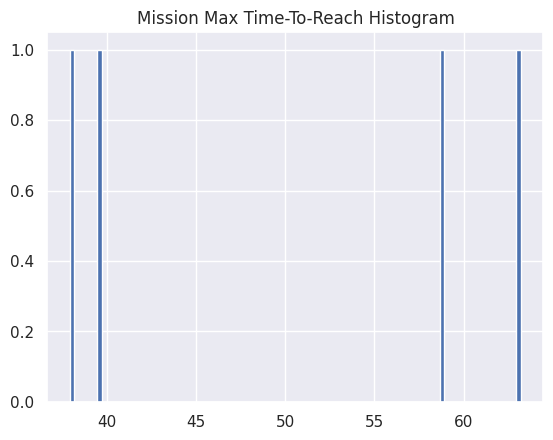

INFO:arena.factory:Downloading 6 files to 'data/miss_gen_hindcast/'.
INFO:arena.factory:File already downloaded: 'GOMu0.04-expt_90.1m000-2022-2022-08-16T00:00:00Z-2022-08-16T23:00:00Z.nc', 0.8MB.
INFO:arena.factory:File already downloaded: 'GOMu0.04-expt_90.1m000-2022-2022-08-17T00:00:00Z-2022-08-17T23:00:00Z.nc', 0.8MB.
INFO:arena.factory:File already downloaded: 'GOMu0.04-expt_90.1m000-2022-2022-08-18T00:00:00Z-2022-08-18T23:00:00Z.nc', 0.8MB.
INFO:arena.factory:File already downloaded: 'GOMu0.04-expt_90.1m000-2022-2022-08-19T00:00:00Z-2022-08-19T23:00:00Z.nc', 0.8MB.
INFO:arena.factory:File already downloaded: 'GOMu0.04-expt_90.1m000-2022-2022-08-20T00:00:00Z-2022-08-20T23:00:00Z.nc', 0.8MB.
INFO:arena.factory:File already downloaded: 'GOMu0.04-expt_90.1m000-2022-2022-08-21T00:00:00Z-2022-08-21T23:00:00Z.nc', 0.8MB.
DEBUG:arena.factory:Hindcast Files: ['data/miss_gen_hindcast/GOMu0.04-expt_90.1m000-2022-2022-08-16T00:00:00Z-2022-08-16T23:00:00Z.nc', 'data/miss_gen_hindcast/GOMu0.04-

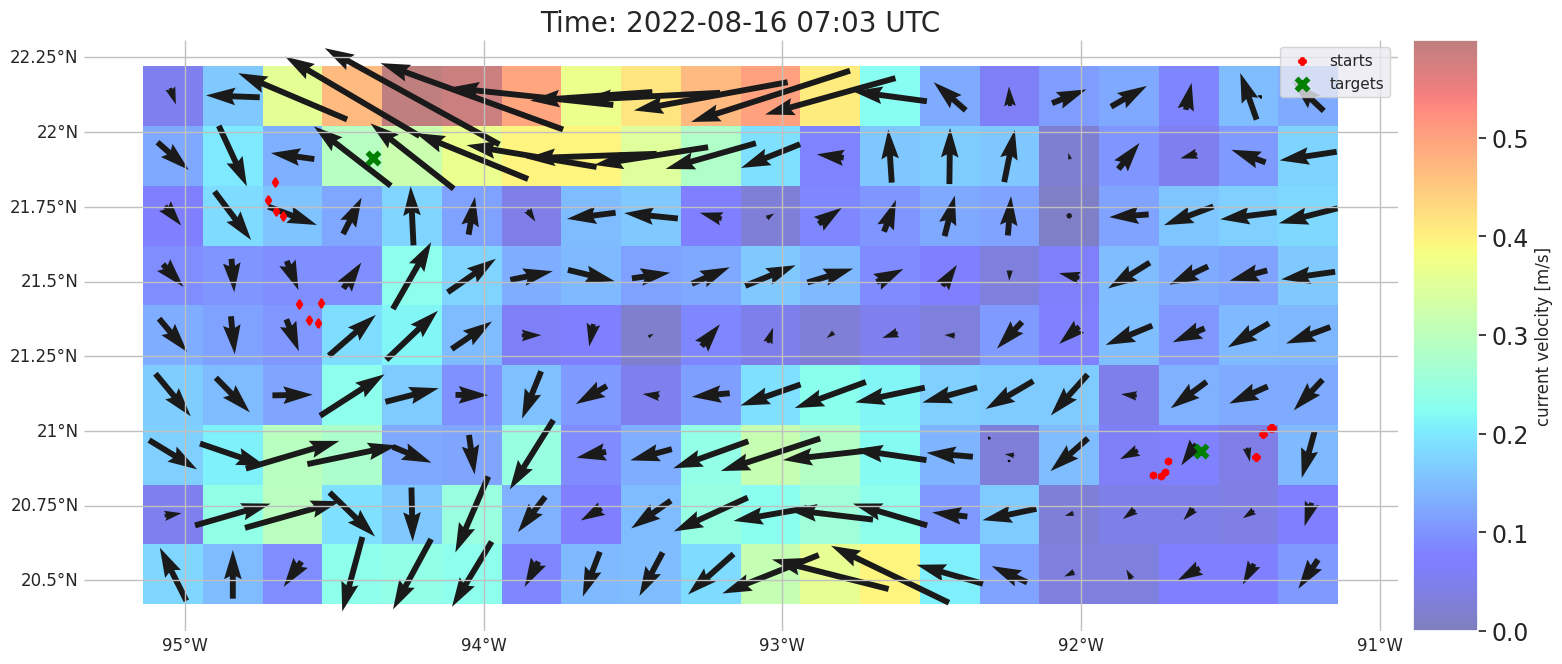

In [4]:
GenerationRunner.plot_ttr_histogram(results_folder)
# visualize only first target and associated starts (which defines a c3 "mission") 
GenerationRunner.plot_starts_and_targets(
    results_folder=results_folder, scenario_config=arena_config,
)

### 4. To c3 mission

In [5]:
exp = []
for idx, problem in enumerate(all_problems):
    try:
        exp.append(problem.to_c3_mission_config())
    except BaseException:
        continue

## Prepare Simulator for a defined mission

## 1. Base config for controller & observer & navigation

In [19]:
NoObserver = {"observer": None}

# Controller Configs
HJMultiTimeConfig = {
    "replan_every_X_seconds": None,
    "replan_on_new_fmrc": True,
    "T_goal_in_seconds": 3600*24*5,  # 3d, 43200,     # 12h
    "accuracy": "high",
    "artificial_dissipation_scheme": "local_local",
    "ctrl_name": "ocean_navigation_simulator.controllers.hj_planners.HJReach2DPlanner.HJReach2DPlanner",
    "d_max": 0.0,
    "deg_around_xt_xT_box": 1.0,
    "direction": "multi-time-reach-back",
    "grid_res": 0.02,
    "n_time_vector": 200,
    "progress_bar": True,
    "use_geographic_coordinate_system": True,
}
StraightLineConfig = {
    "ctrl_name": "ocean_navigation_simulator.controllers.NaiveController.NaiveController"
}
flockingConfig = {
    "unit": "km",
    "interaction_range": 9,  # km
    "grad_clip_range": 0.1,  # km
}
reactiveConfig = {
    "unit": "m",
    "mix_ttr_and_euclidean": True,
    "delta_3": 8800, # collision threshold (communication - delta_3)
    "delta_2": 2000, # safe zone threshold  ]communication - delta_2, communication - delta_3[
    "delta_1": 500, # small threshold so that if distance > communication_thrsld- delta_1 we try to achieve connectivity
    "communication_thrsld": 9000,
    "k_1": 0.25,
    "k_2": 1}

MultiAgentCtrlConfig = {
    "ctrl_name": "ocean_navigation_simulator.controllers.MultiAgentPlanner.MultiAgentPlanner",
    "high_level_ctrl": "hj_naive", #choose from hj_naive, flocking, reactive_control
    "unit": "km",
    "communication_thrsld": 9,
    "hj_specific_settings": HJMultiTimeConfig,
}
objective_conf = {"type": "nav"}

## 2. Constructor

INFO:arena.factory:Downloading 10 files to 'data/miss_gen_hindcast/'.
INFO:arena.factory:File already downloaded: 'GOMu0.04-expt_90.1m000-2022-2022-08-16T00:00:00Z-2022-08-16T23:00:00Z.nc', 0.8MB.
INFO:arena.factory:File already downloaded: 'GOMu0.04-expt_90.1m000-2022-2022-08-17T00:00:00Z-2022-08-17T23:00:00Z.nc', 0.8MB.
INFO:arena.factory:File already downloaded: 'GOMu0.04-expt_90.1m000-2022-2022-08-18T00:00:00Z-2022-08-18T23:00:00Z.nc', 0.8MB.
INFO:arena.factory:File already downloaded: 'GOMu0.04-expt_90.1m000-2022-2022-08-19T00:00:00Z-2022-08-19T23:00:00Z.nc', 0.8MB.
INFO:arena.factory:File already downloaded: 'GOMu0.04-expt_90.1m000-2022-2022-08-20T00:00:00Z-2022-08-20T23:00:00Z.nc', 0.8MB.
INFO:arena.factory:File already downloaded: 'GOMu0.04-expt_90.1m000-2022-2022-08-21T00:00:00Z-2022-08-21T23:00:00Z.nc', 0.8MB.
INFO:arena.factory:File already downloaded: 'GOMu0.04-expt_90.1m000-2022-2022-08-22T00:00:00Z-2022-08-22T23:00:00Z.nc', 0.8MB.
INFO:arena.factory:File already downloade

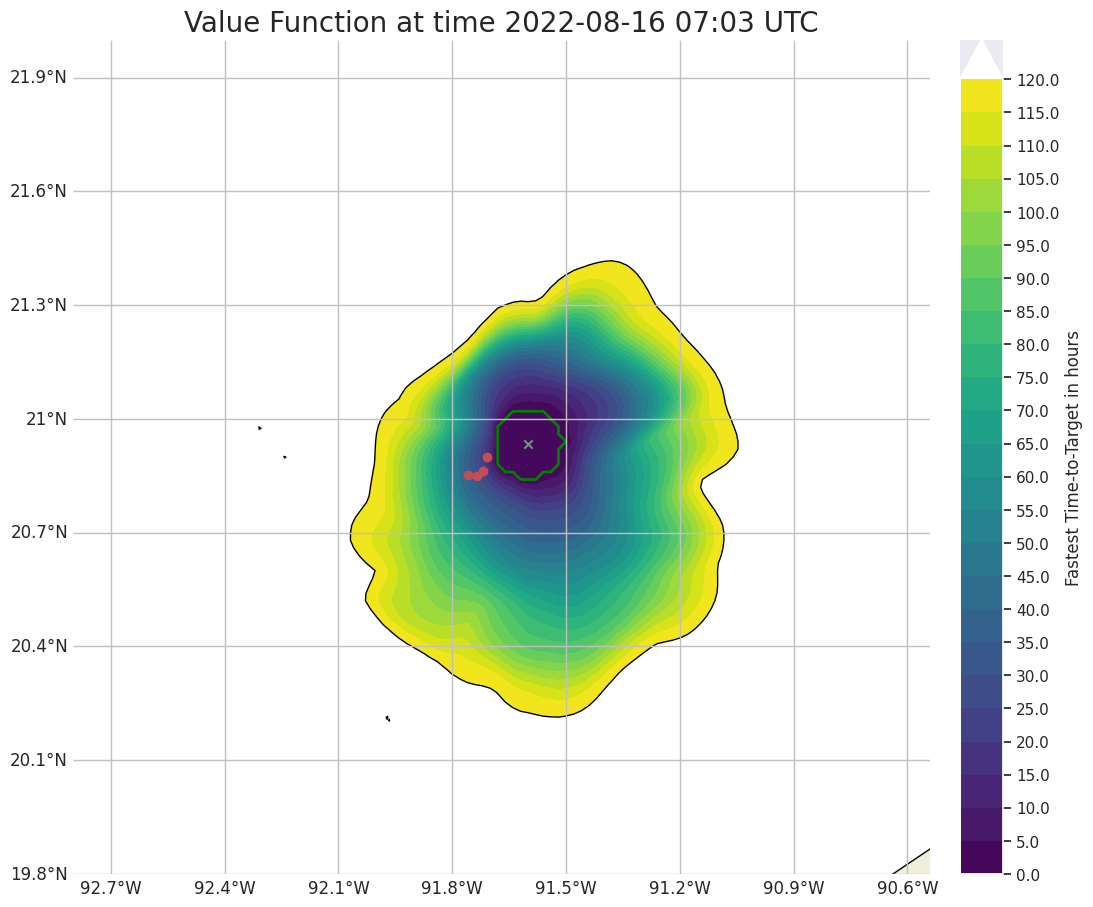

In [23]:
# choose mission we want to simulate (1 target per mission)
idx_mission = 1
mission_config = exp[idx_mission]

# Step 0: Create Constructor object which contains arena, problem, controller and observer
constructor = Constructor(
    arena_conf=arena_config,
    mission_conf=mission_config,
    objective_conf=objective_conf,
    ctrl_conf=MultiAgentCtrlConfig,  # here different controller configs can be put in
    observer_conf=NoObserver,  # here the other observers can also be put int
    download_files=True,
    timeout_in_sec=config["problem_timeout_in_h"]*3600, # experiment config
)
# Step 1.1 Retrieve problem
problem = constructor.problem

# Step 1.2: Retrieve arena
arena = constructor.arena
observation = arena.reset(platform_set=problem.start_state)
problem_status = arena.problem_status(problem=problem)
# #%% Plot the problem on the map
# import matplotlib.pyplot as plt
# t_interval, lat_bnds, lon_bnds = arena.ocean_field.hindcast_data_source.convert_to_x_y_time_bounds(
#     x_0=problem.start_state.to_spatio_temporal_point(), x_T=problem.end_region,
#     deg_around_x0_xT_box=1, temp_horizon_in_s=3600
# )
#
# ax = arena.ocean_field.hindcast_data_source.plot_data_at_time_over_area(
#     time=problem.start_state.date_time, x_interval=lon_bnds, y_interval=lat_bnds, return_ax=True
# )
# problem.plot(ax=ax)
# plt.show()

# Step 2: Retrieve Controller
# problem.platform_dict = arena.platform.platform_dict
controller = constructor.controller
# Reachability snapshot plot
action = controller.get_action(observation=observation)
controller.plot_reachability_snapshot(
    rel_time_in_seconds=0,
    granularity_in_h=5,
    alpha_color=1,
    time_to_reach=True,
    fig_size_inches=(12, 12),
    plot_in_h=True,
    return_ax=True,
)
plt.show()
# Step 3: Retrieve observer
observer = constructor.observer

### 3. Run closed-loop simulation

In [24]:
# Step 4: Run closed-loop simulation
ctrl_deviation_from_opt = []
all_pltf_status = [0]*len(mission_config["x_0"])
while any(status == 0 for status in problem_status):
    # Get action
    action, ctrl_correction = controller.get_action(observation=observation)
    ctrl_deviation_from_opt.append(ctrl_correction)
    # execute action
    observation = arena.step(action)

    # Observer data assimilation
    observer.observe(observation)
    observation.forecast_data_source = observer

    # update problem status
    problem_status = arena.problem_status(problem=problem)

    # for the final metric, look if platform was able to reach target within T, so keep only max (=1 if pltf reached target)
    all_pltf_status = list(map(max, zip(all_pltf_status, problem_status)))

print("terminated because:", arena.problem_status_text(arena.problem_status(problem=problem)))

DEBUG:arena.controller:HJPlannerBase: Get Action from Plan (0.2s)
DEBUG:arena.controller:HJPlannerBase: Get Action from Plan (0.1s)
DEBUG:arena.controller:HJPlannerBase: Get Action from Plan (0.2s)
DEBUG:arena.controller:HJPlannerBase: Get Action from Plan (0.1s)
DEBUG:arena:Platform Step (2.30ms)
DEBUG:arena:Create Observation (1.72ms)
DEBUG:arena.controller:HJPlannerBase: Get Action from Plan (0.1s)
DEBUG:arena.controller:HJPlannerBase: Get Action from Plan (0.1s)
DEBUG:arena.controller:HJPlannerBase: Get Action from Plan (0.1s)
DEBUG:arena.controller:HJPlannerBase: Get Action from Plan (0.1s)
DEBUG:arena:Platform Step (1.09ms)
DEBUG:arena:Create Observation (0.91ms)
DEBUG:arena.controller:HJPlannerBase: Get Action from Plan (0.1s)
DEBUG:arena.controller:HJPlannerBase: Get Action from Plan (0.1s)
DEBUG:arena.controller:HJPlannerBase: Get Action from Plan (0.1s)
DEBUG:arena.controller:HJPlannerBase: Get Action from Plan (0.1s)
DEBUG:arena:Platform Step (0.95ms)
DEBUG:arena:Create Obse

terminated because: Success: all the platforms reached the target within time


### 4. Get metrics

INFO:/home/nicolas/documents/Master_Thesis_repo/OceanPlatformControl/tmp/missions/results_hj_naive/metrics_1.log:
Integral metric of isolated platforms = 0.0            
Number of collisions = 0            
Fraction of platforms reaching target = 1.0            
Average Beta Index = 1.5            
Initial maximum degree of the graph = 3            
Final maximum degree of the graph = 3            
Mean maximum correction from optimal control, in degrees = 0.0
INFO:/home/nicolas/documents/Master_Thesis_repo/OceanPlatformControl/tmp/missions/results_hj_naive/metrics_1.log:True


<Figure size 640x480 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

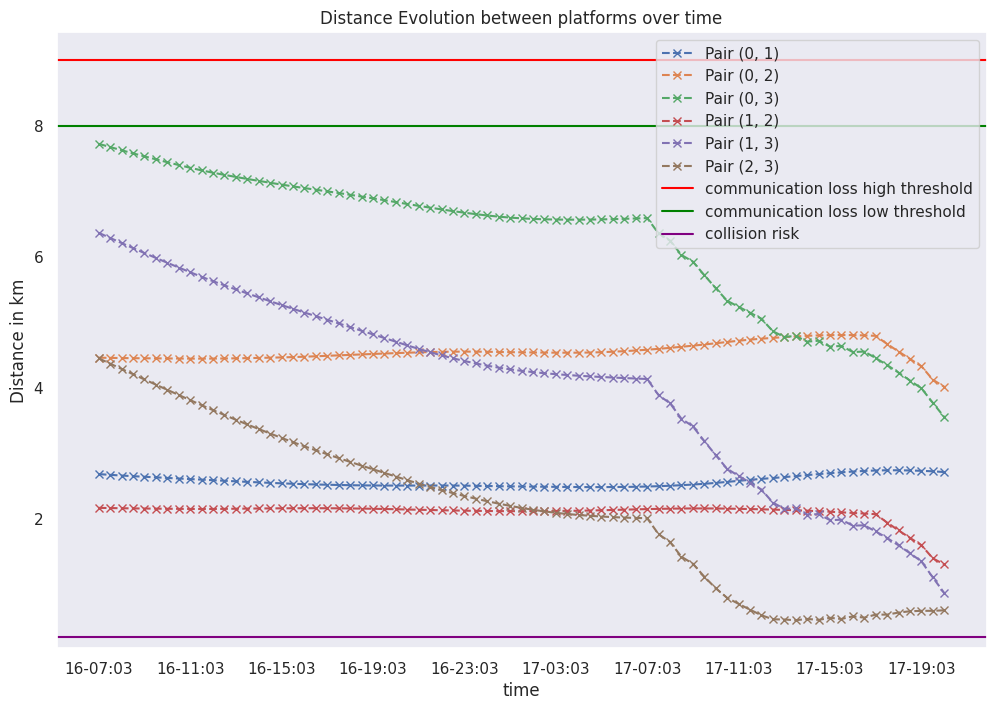

In [25]:
metrics_folder = os.path.join(results_folder, "results_" + MultiAgentCtrlConfig["high_level_ctrl"])
os.makedirs(metrics_folder, exist_ok=True)
with open(f'{results_folder}/mission_config_{idx_mission}.yml', 'w') as outfile:
    yaml.dump(mission_config, outfile, default_flow_style=False)

metrics_dict = arena.save_metrics_to_log(
    all_pltf_status=all_pltf_status,
    max_correction_from_opt_ctrl=ctrl_deviation_from_opt,
    filename=f"{metrics_folder}/metrics_{idx_mission}.log",
)
metrics_df = pd.DataFrame(data=metrics_dict, index=[idx_mission])
metrics_df.to_csv(f"{results_folder}/metrics.csv")

arena.animate_trajectory(
    margin=0.25,
    problem=problem,
    temporal_resolution=7200,
    output=f"{metrics_folder}/platform_trajectories_{idx_mission}.mp4",
    fps=6,
)

arena.animate_graph_net_trajectory(
    temporal_resolution=7200,
    # collision_communication_thrslds=(10, 50), (not specified take defaut one)
    plot_ax_ticks=True,
    output=f"{metrics_folder}/network_graph_trajectory_{idx_mission}.mp4",
    fps=5,
)
# %% Plot useful metrics for multi-agent performance evaluation
plt.clf()
fig = arena.plot_all_network_analysis(xticks_temporal_res=8 * 3600)  # 8 hours interval for xticks
plt.savefig(f"{metrics_folder}/graph_properties_{idx_mission}.png")
plt.clf()
arena.plot_distance_evolution_between_platforms()
plt.savefig(f"{metrics_folder}/distanceEvolution_{idx_mission}.png")